# Analise Series Temporais - Arima

In [27]:
# Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy as np

In [28]:
# Carregando os dados
df = pd.read_csv('../../datasets/vendas_mensais.csv')

In [29]:
#Convertando  data para DateTime
df['data'] = pd.to_datetime(df['data'], format='%Y-%m')
df.set_index('data', inplace=True)

In [30]:
# Frequência mensal para a série
df = df.asfreq('MS')

In [31]:
# Informações dataset
df.head()

,vendas
data,
2020-01-01,100
2020-02-01,120
2020-03-01,115
2020-04-01,130
2020-05-01,140


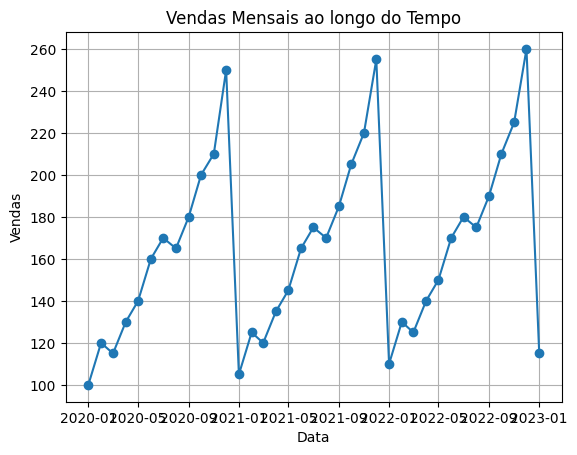

In [32]:
# Visualização da Série
plt.figure()
plt.plot(df.index, df['vendas'], marker='o', linestyle='-')
plt.title('Vendas Mensais ao longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.grid(True)
plt.show()

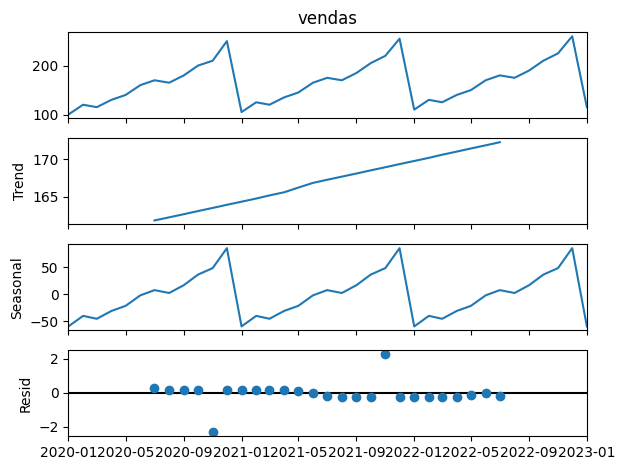

In [33]:
# Decomposição Sazonal
decomposicao = seasonal_decompose(df['vendas'], model='additive', period=12)
decomposicao.plot()
plt.show()

In [34]:
# Teste de Estacionariedade - Dickey-Fuller
resultado_adf = adfuller(df['vendas'])
print('Teste de Dickey-Fuller ADF:')
print(f"Estatística ADF: {resultado_adf[0]:.4f}")
print(f"p-Valor: {resultado_adf[1]:.4f}")
for key, value in resultado_adf[4].items():
    print(f"Corte crítico {key}: {value:.4f}")

Teste de Dickey-Fuller ADF:
Estatística ADF: -4.0263
p-Valor: 0.0013
Corte crítico 1%: -3.7112
Corte crítico 5%: -2.9812
Corte crítico 10%: -2.6301


In [35]:
# Aplicar Diferenciação
df['vendas_diff'] = df['vendas'] - df['vendas'].shift(1)
df['vendas_diff'] = df['vendas_diff'].dropna()

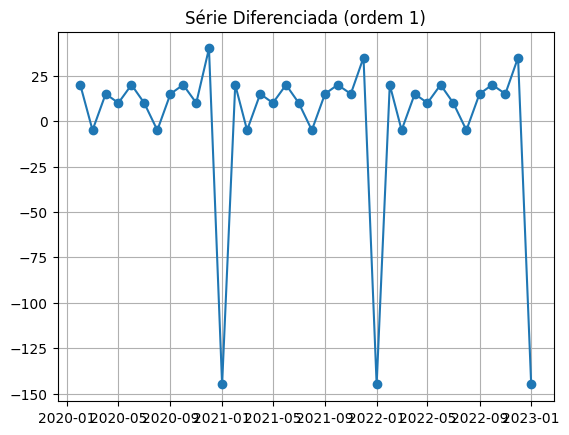

In [36]:
# Visualização
plt.figure()
plt.plot(df.index, df['vendas_diff'], marker='o', linestyle='-')
plt.title('Série Diferenciada (ordem 1)')
plt.grid(True)
plt.show()

In [37]:
# Separar dados em treino e teste
tamanho_treino = int(len(df)*0.8)
df_treino = df.iloc[:tamanho_treino]
df_teste = df.iloc[tamanho_treino:]

In [38]:
# Ajustar o modelo Arima
ordem = (1,1,1)
modelo = ARIMA(df_treino['vendas'], order=ordem)
modelo_treinado = modelo.fit()
modelo_treinado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 vendas   No. Observations:                   29
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -141.828
Date:                Fri, 14 Mar 2025   AIC                            289.657
Time:                        02:11:42   BIC                            293.653
Sample:                    01-01-2020   HQIC                           290.878
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5268      0.345      1.527      0.127      -0.149       1.203
ma.L1         -0.9994     20.741     -0.048      0.962     -41.652      39.653
sigma2      1355.6289   2.79e+04      0.049      0.961   -5.33e+04     5.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                29.51
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               4.02   Skew:                            -1.73
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# Previsão no período de teste
previsoes = modelo_treinado.forecast(steps=len(df_teste))

In [40]:
# Avaliação da Performace
df_teste['previsao'] = previsoes

C:\Users\josaf\AppData\Local\Temp\ipykernel_12584\2805759903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['previsao'] = previsoes


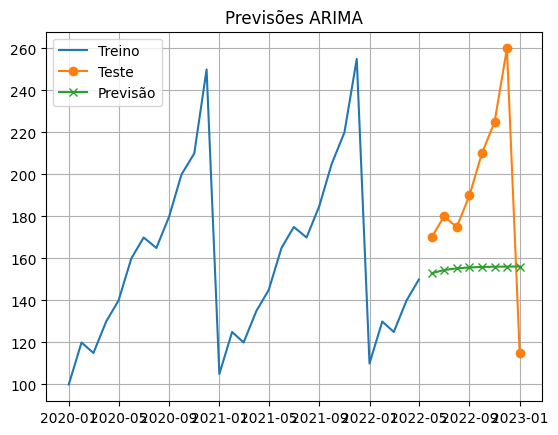

In [41]:
# Visualização
plt.figure()
plt.plot(df_treino.index, df_treino['vendas'], label="Treino")
plt.plot(df_teste.index, df_teste['vendas'], label='Teste', marker='o')
plt.plot(df_teste.index, df_teste['previsao'], label='Previsão', marker='x')
plt.title('Previsões ARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
def MAPE(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [43]:
mape = MAPE(df_teste['vendas'], df_teste['previsao'])
mae = np.mean(np.abs(df_teste['vendas'] - df_teste['previsao']))
rmse = np.sqrt(np.mean((df_teste['vendas'] - df_teste['previsao'])**2))

In [44]:
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 23.20%
MAE: 45.57
RMSE: 53.22


In [45]:
# Ajuste SARIMA
modelo_sarima = sm.tsa.statespace.SARIMAX(df_treino['vendas'], order=ordem, seasonal_order=(1,1,1,12))
modelo_sarima_treinado = modelo_sarima.fit()
previsoes_sarima = modelo_sarima_treinado.forecast(steps=len(df_teste))

c:\Users\josaf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\josaf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
# Avaliação da Performace
df_teste['previsao'] = previsoes_sarima

C:\Users\josaf\AppData\Local\Temp\ipykernel_12584\2501362719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['previsao'] = previsoes_sarima


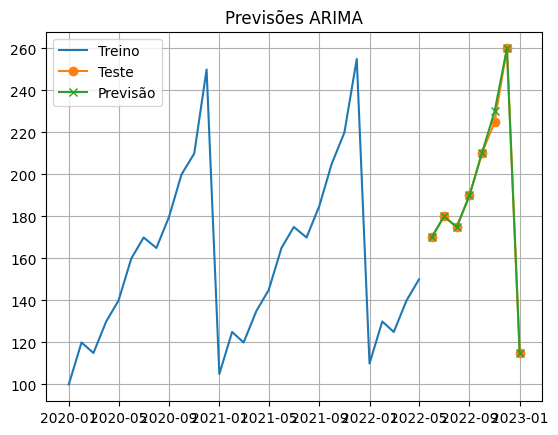

In [47]:
# Visualização
plt.figure()
plt.plot(df_treino.index, df_treino['vendas'], label="Treino")
plt.plot(df_teste.index, df_teste['vendas'], label='Teste', marker='o')
plt.plot(df_teste.index, df_teste['previsao'], label='Previsão', marker='x')
plt.title('Previsões ARIMA')
plt.legend()
plt.grid(True)
plt.show()